In [1]:
# Fun some setup for the project
# Silence annoying pytorch deprecated warnings
import warnings
warnings.filterwarnings("ignore")

from train import *
from create_graphs import *
%matplotlib inline

print ('CUDA Available:', torch.cuda.is_available())

CUDA Available: True


In [ ]:
def 

In [2]:
# Generate the model datasets (i.e. the dataset used to train
# the model - normal data)
args_enzy1, train_enzy1, val_enzy1, test_enzy1 = get_graph_data("enzymes_1", isModelDataset=True)
# Save the max_previous node to allow for model 
# compatability on future datasets
max_prev_node = args_enzy1.max_prev_node

Loading graph dataset: ENZYMES
Loaded
Average num nodes 36.505050505050505
total graph num: 99
max number node: 125
max/min number edge: 149; 26
max previous node: 25


In [3]:
# Initialize the dataset and dataloader for analyzing the nlls. 
# Note that we use batch_size = 1 because we want the nll for each
# data point not an average across a batch.
# We should also consider using Graph_sequence_Sampler_pytorch_nll.
# This sampler expands the size of the dataset by for each graph 
# creating many different bfs permutations. The idea behind this sampler
# is to test the models permutation invariance. 

train_dataset = Graph_sequence_sampler_pytorch_rand(train_enzy1,max_prev_node=args_enzy1.max_prev_node,max_num_node=args_enzy1.max_num_node)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, num_workers=args_enzy1.num_workers)

test_dataset = Graph_sequence_sampler_pytorch_rand(test_enzy1, max_prev_node=args_enzy1.max_prev_node,max_num_node=args_enzy1.max_num_node)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, num_workers=args_enzy1.num_workers)

In [4]:
# Model initialization
# Using GraphRNN

rnn = GRU_plain(input_size=args_enzy1.max_prev_node, embedding_size=args_enzy1.embedding_size_rnn,
                        hidden_size=args_enzy1.hidden_size_rnn, num_layers=args_enzy1.num_layers, has_input=True,
                        has_output=True, output_size=args_enzy1.hidden_size_rnn_output).to(device)
output = GRU_plain(input_size=1, embedding_size=args_enzy1.embedding_size_rnn_output,
                        hidden_size=args_enzy1.hidden_size_rnn_output, num_layers=args_enzy1.num_layers, has_input=True,
                        has_output=True, output_size=1).to(device)

In [6]:
# Let's do some analysis on the training data
nlls, avg_nlls = calc_nll(args_enzy1, train_loader, rnn, output, max_iter=25,log=5)

./model_save/GraphRNN_RNN_enzymes_1_4_128_lstm_3000.dat
model loaded!, epoch: 3000
Iteration: 5
Average Nll over train data: 56.39157256597205
Iteration: 10
Average Nll over train data: 58.69773966149439
Iteration: 15
Average Nll over train data: 59.755778059174744
Iteration: 20
Average Nll over train data: 61.66705881191206
Iteration: 25
Average Nll over train data: 56.31952186777622


In [8]:
avg_nlls_iter = np.array(avg_nlls)
avg_nlls_iter = avg_nlls_iter.reshape((25, len(train_loader)))
avg_nlls_iter = np.mean(avg_nlls_iter, axis=0)

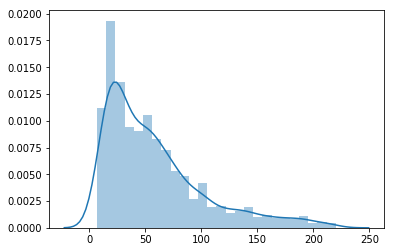

In [9]:
# Plot un averaged nlls (over the feature dimensions of the graph sequence) for the model's training dataset
plt.figure()
hist = sns.distplot(nlls,kde=True)

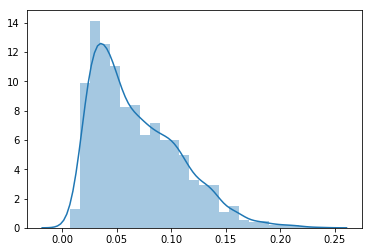

In [10]:
# Plot un averaged nlls (over the feature dimensions of the graph sequence) for the model's training dataset
plt.figure()
hist = sns.distplot(avg_nlls,kde=True)

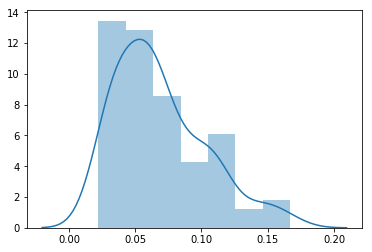

In [11]:
# Average the likelihoods across the iterations for each graph
plt.figure()
sns.distplot(avg_nlls_iter,kde=True)

In [12]:
# Analysis of the test data set nlls.
# We really gotta train over more data!
test_nlls, test_avg_nlls = calc_nll(args_enzy1, test_loader, rnn, output, max_iter=25, log=5)

./model_save/GraphRNN_RNN_enzymes_1_4_128_lstm_3000.dat
model loaded!, epoch: 3000
Iteration: 5
Average Nll over train data: 150.04536933898925
Iteration: 10
Average Nll over train data: 171.997700881958
Iteration: 15
Average Nll over train data: 142.23736362457277
Iteration: 20
Average Nll over train data: 149.91487855911254
Iteration: 25
Average Nll over train data: 153.09829740524293


In [13]:
test_avg_nlls_iter = np.array(test_avg_nlls)
test_avg_nlls_iter = test_avg_nlls_iter.reshape((25, len(test_loader)))
test_avg_nlls_iter = np.mean(test_avg_nlls_iter, axis=0)

Text(0.5,1,'NLL summed across features')

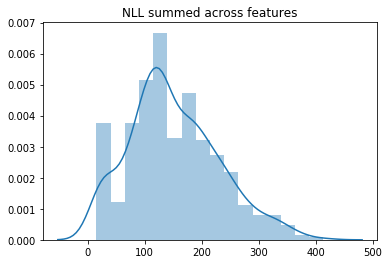

In [14]:
# Un-averaged nlls over the test normal distribution
plt.figure()
sns.distplot(test_nlls, kde=True)
plt.title('NLL summed across features')

Text(0.5,1,'NLL averaged over Features and Iterations ')

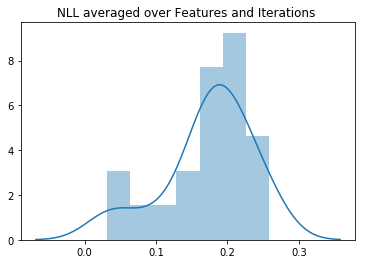

In [25]:
# Average the likelihoods across the iterations for each graph
plt.figure()
sns.distplot(test_avg_nlls_iter,kde=True)
plt.title("NLL averaged over Features and Iterations ")

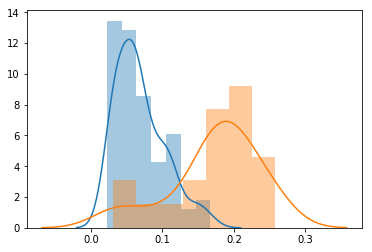

In [16]:
fig, ax = plt.subplots()
for a in [avg_nlls_iter, test_avg_nlls_iter]:
    sns.distplot(a, ax=ax, kde=True)

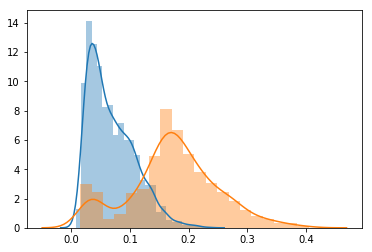

In [18]:
fig, ax = plt.subplots()
for a in [avg_nlls, test_avg_nlls]:
    sns.distplot(a, ax=ax, kde=True)

# Now we will test the enzymes with different labels

## Enzyme 2

In [22]:
# Starting with enzyme with label 2
args_enzy2, graphs_enzy2 = get_graph_data("enzymes_2", isModelDataset=False)

# Create dataset and dataloader object for the out of distribution ladder dataset
# Note that instead of passing in args.max_prev_node, we pass in the saved max_prev_node
# saved specifically for the enzyme dataset - hack to allow for GraphRNN to work on any dataset
enzy2_dataset = Graph_sequence_sampler_pytorch_rand(graphs_enzy2,max_prev_node=max_prev_node,max_num_node=args_enzy2.max_num_node)
enzy2_loader = torch.utils.data.DataLoader(enzy2_dataset, batch_size=1, num_workers=args_enzy2.num_workers)

# Let's see how the nlls of the ladder graphs compare to 
# the trained on enzymes.
# Note we pass in the args_enzy because the model we are
# using are trained in the enzyme dataset
enzy2_nlls, enzy2_avg_nlls = calc_nll(args_enzy1, enzy2_loader, rnn, output, max_iter=25, train_dataset="enzymes_1", log=5)

enzy2_avg_nlls_iter = np.array(enzy2_avg_nlls)
enzy2_avg_nlls_iter = enzy2_avg_nlls_iter.reshape((25, len(enzy2_loader)))
enzy2_avg_nlls_iter = np.mean(enzy2_avg_nlls_iter, axis=0)


Loading graph dataset: ENZYMES
Loaded
Average num nodes 30.367346938775512
total graph num: 98
max number node: 66
max/min number edge: 118; 17
max previous node: 25
./model_save/GraphRNN_RNN_enzymes_1_4_128_lstm_3000.dat
model loaded!, epoch: 3000
Iteration: 5
Average Nll over train data: 143.13115281474833
Iteration: 10
Average Nll over train data: 145.43140070778983
Iteration: 15
Average Nll over train data: 140.05662517158353
Iteration: 20
Average Nll over train data: 144.0331088085564
Iteration: 25
Average Nll over train data: 141.44381168910436


Text(0.5,1,'Comparison of Enzy1 and Enzy2 (avg nll over iteration)')

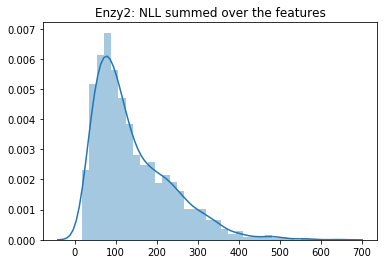

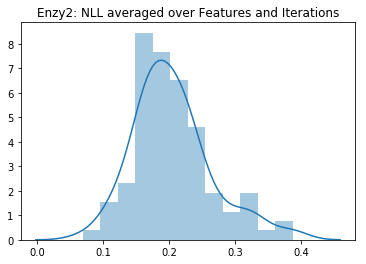

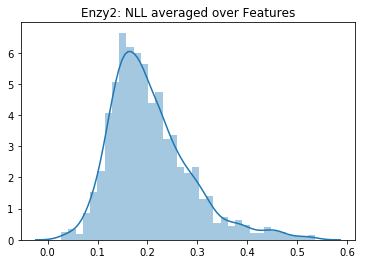

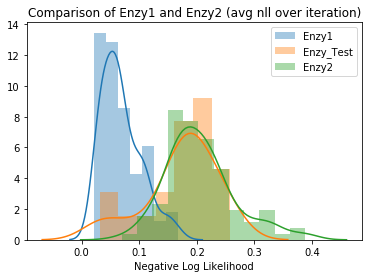

In [27]:
# Un-averaged nlls over the ladder normal distribution
plt.figure()
hist = sns.distplot(enzy2_nlls, kde=True)
plt.title("Enzy2: NLL summed over the features")

# Average the likelihoods across the iterations for each graph
plt.figure()
sns.distplot(enzy2_avg_nlls_iter,kde=True)
plt.title("Enzy2: NLL averaged over Features and Iterations")

# Average the likelihoods across the iterations for each graph
plt.figure()
sns.distplot(enzy2_avg_nlls,kde=True)
plt.title("Enzy2: NLL averaged over Features")

fig, ax = plt.subplots()
labels = ["Enzy1", "Enzy_Test", "Enzy2"]
likelihoods = [avg_nlls_iter, test_avg_nlls_iter, enzy2_avg_nlls_iter]
for i in range(len(labels)):
    sns.distplot(likelihoods[i], ax=ax, kde=True, label=labels[i])
ax.set_xlabel("Negative Log Likelihood")
ax.legend()
plt.title('Comparison of Enzy1 and Enzy2 (avg nll over iteration)')

## Enzyme 3

In [28]:
# Starting with enzyme with label 2
args_enzy3, graphs_enzy3 = get_graph_data("enzymes_3", isModelDataset=False)

# Create dataset and dataloader object for the out of distribution ladder dataset
# Note that instead of passing in args.max_prev_node, we pass in the saved max_prev_node
# saved specifically for the enzyme dataset - hack to allow for GraphRNN to work on any dataset
enzy3_dataset = Graph_sequence_sampler_pytorch_rand(graphs_enzy3,max_prev_node=max_prev_node,max_num_node=args_enzy3.max_num_node)
enzy3_loader = torch.utils.data.DataLoader(enzy3_dataset, batch_size=1, num_workers=args_enzy3.num_workers)

# Let's see how the nlls of the ladder graphs compare to 
# the trained on enzymes.
# Note we pass in the args_enzy because the model we are
# using are trained in the enzyme dataset
enzy3_nlls, enzy3_avg_nlls = calc_nll(args_enzy1, enzy3_loader, rnn, output, max_iter=25, train_dataset="enzymes_1", log=5)

enzy3_avg_nlls_iter = np.array(enzy3_avg_nlls)
enzy3_avg_nlls_iter = enzy3_avg_nlls_iter.reshape((25, len(enzy3_loader)))
enzy3_avg_nlls_iter = np.mean(enzy3_avg_nlls_iter, axis=0)


Loading graph dataset: ENZYMES
Loaded
Average num nodes 28.9
total graph num: 100
max number node: 60
max/min number edge: 99; 23
max previous node: 25
./model_save/GraphRNN_RNN_enzymes_1_4_128_lstm_3000.dat
model loaded!, epoch: 3000
Iteration: 5
Average Nll over train data: 124.64854957580566
Iteration: 10
Average Nll over train data: 122.63818243026734
Iteration: 15
Average Nll over train data: 121.50610679626465
Iteration: 20
Average Nll over train data: 119.70678886413575
Iteration: 25
Average Nll over train data: 121.12384796142578


Text(0.5,1,'Comparison of Enzy1 and Enzy3 (avg nll over iteration)')

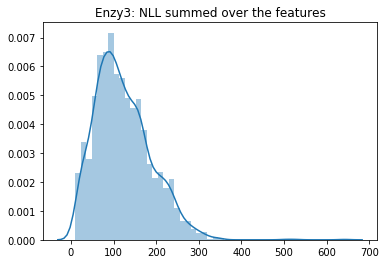

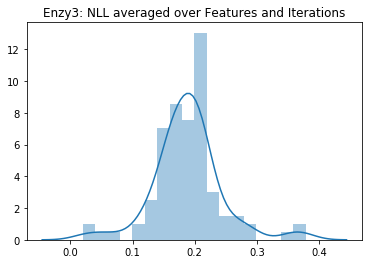

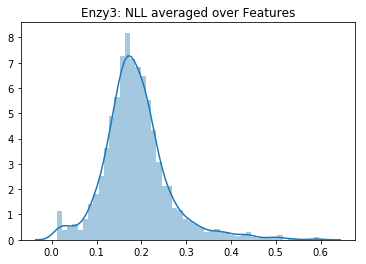

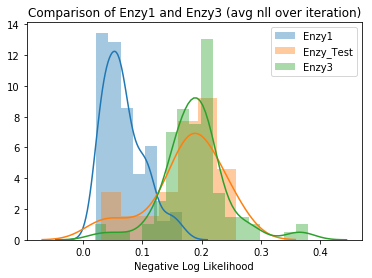

In [30]:
# Un-averaged nlls over the ladder normal distribution
plt.figure()
hist = sns.distplot(enzy3_nlls, kde=True)
plt.title("Enzy3: NLL summed over the features")

# Average the likelihoods across the iterations for each graph
plt.figure()
sns.distplot(enzy3_avg_nlls_iter,kde=True)
plt.title("Enzy3: NLL averaged over Features and Iterations")

# Average the likelihoods across the iterations for each graph
plt.figure()
sns.distplot(enzy3_avg_nlls,kde=True)
plt.title("Enzy3: NLL averaged over Features")

fig, ax = plt.subplots()
labels = ["Enzy1", "Enzy_Test", "Enzy3"]
likelihoods = [avg_nlls_iter, test_avg_nlls_iter, enzy3_avg_nlls_iter]
for i in range(len(labels)):
    sns.distplot(likelihoods[i], ax=ax, kde=True, label=labels[i])
ax.set_xlabel("Negative Log Likelihood")
ax.legend()
plt.title('Comparison of Enzy1 and Enzy3 (avg nll over iteration)')

## Enzyme 4

In [31]:
# Starting with enzyme with label 2
args_enzy4, graphs_enzy4 = get_graph_data("enzymes_4", isModelDataset=False)

# Create dataset and dataloader object for the out of distribution ladder dataset
# Note that instead of passing in args.max_prev_node, we pass in the saved max_prev_node
# saved specifically for the enzyme dataset - hack to allow for GraphRNN to work on any dataset
enzy4_dataset = Graph_sequence_sampler_pytorch_rand(graphs_enzy4,max_prev_node=max_prev_node,max_num_node=args_enzy4.max_num_node)
enzy4_loader = torch.utils.data.DataLoader(enzy4_dataset, batch_size=1, num_workers=args_enzy4.num_workers)

# Let's see how the nlls of the ladder graphs compare to 
# the trained on enzymes.
# Note we pass in the args_enzy because the model we are
# using are trained in the enzyme dataset
enzy4_nlls, enzy4_avg_nlls = calc_nll(args_enzy1, enzy4_loader, rnn, output, max_iter=25, train_dataset="enzymes_1", log=5)

enzy4_avg_nlls_iter = np.array(enzy4_avg_nlls)
enzy4_avg_nlls_iter = enzy4_avg_nlls_iter.reshape((25, len(enzy4_loader)))
enzy4_avg_nlls_iter = np.mean(enzy4_avg_nlls_iter, axis=0)

Loading graph dataset: ENZYMES
Loaded
Average num nodes 37.91
total graph num: 100
max number node: 74
max/min number edge: 120; 31
max previous node: 25
./model_save/GraphRNN_RNN_enzymes_1_4_128_lstm_3000.dat
model loaded!, epoch: 3000
Iteration: 5
Average Nll over train data: 197.72286293029785
Iteration: 10
Average Nll over train data: 184.37240880966186
Iteration: 15
Average Nll over train data: 192.24791431427002
Iteration: 20
Average Nll over train data: 191.93226013183593
Iteration: 25
Average Nll over train data: 187.3062982749939


Text(0.5,1,'Comparison of Enzy1 and Enzy4 (avg nll over iteration)')

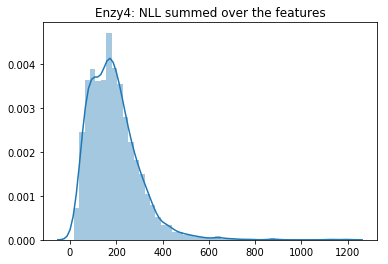

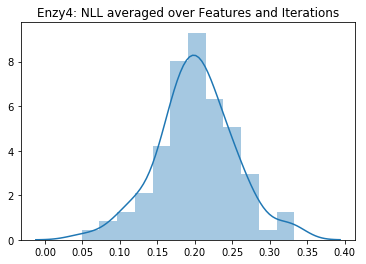

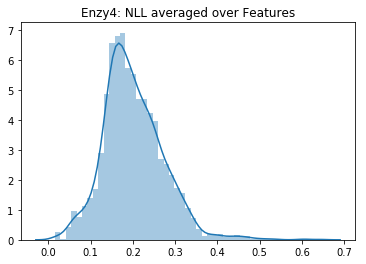

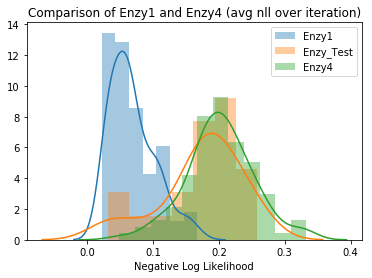

In [32]:
# Un-averaged nlls over the ladder normal distribution
plt.figure()
hist = sns.distplot(enzy4_nlls, kde=True)
plt.title("Enzy4: NLL summed over the features")

# Average the likelihoods across the iterations for each graph
plt.figure()
sns.distplot(enzy4_avg_nlls_iter,kde=True)
plt.title("Enzy4: NLL averaged over Features and Iterations")

# Average the likelihoods across the iterations for each graph
plt.figure()
sns.distplot(enzy4_avg_nlls,kde=True)
plt.title("Enzy4: NLL averaged over Features")

fig, ax = plt.subplots()
labels = ["Enzy1", "Enzy_Test", "Enzy4"]
likelihoods = [avg_nlls_iter, test_avg_nlls_iter, enzy4_avg_nlls_iter]
for i in range(len(labels)):
    sns.distplot(likelihoods[i], ax=ax, kde=True, label=labels[i])
ax.set_xlabel("Negative Log Likelihood")
ax.legend()
plt.title('Comparison of Enzy1 and Enzy4 (avg nll over iteration)')

## Enzyme 5

In [33]:
# Starting with enzyme with label 2
args_enzy5, graphs_enzy5 = get_graph_data("enzymes_5", isModelDataset=False)

# Create dataset and dataloader object for the out of distribution ladder dataset
# Note that instead of passing in args.max_prev_node, we pass in the saved max_prev_node
# saved specifically for the enzyme dataset - hack to allow for GraphRNN to work on any dataset
enzy5_dataset = Graph_sequence_sampler_pytorch_rand(graphs_enzy5,max_prev_node=max_prev_node,max_num_node=args_enzy5.max_num_node)
enzy5_loader = torch.utils.data.DataLoader(enzy5_dataset, batch_size=1, num_workers=args_enzy5.num_workers)

# Let's see how the nlls of the ladder graphs compare to 
# the trained on enzymes.
# Note we pass in the args_enzy because the model we are
# using are trained in the enzyme dataset
enzy5_nlls, enzy5_avg_nlls = calc_nll(args_enzy1, enzy5_loader, rnn, output, max_iter=25, train_dataset="enzymes_1", log=5)

enzy5_avg_nlls_iter = np.array(enzy5_avg_nlls)
enzy5_avg_nlls_iter = enzy5_avg_nlls_iter.reshape((25, len(enzy5_loader)))
enzy5_avg_nlls_iter = np.mean(enzy5_avg_nlls_iter, axis=0)

Loading graph dataset: ENZYMES
Loaded
Average num nodes 32.123711340206185
total graph num: 97
max number node: 95
max/min number edge: 127; 20
max previous node: 25
./model_save/GraphRNN_RNN_enzymes_1_4_128_lstm_3000.dat
model loaded!, epoch: 3000
Iteration: 5
Average Nll over train data: 156.19495848036303
Iteration: 10
Average Nll over train data: 158.02683545142105
Iteration: 15
Average Nll over train data: 155.30427492279367
Iteration: 20
Average Nll over train data: 155.27324871181213
Iteration: 25
Average Nll over train data: 152.20426734452394


Text(0.5,1,'Comparison of Enzy1 and Enzy5 (avg nll over iteration)')

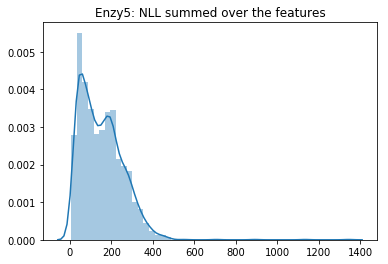

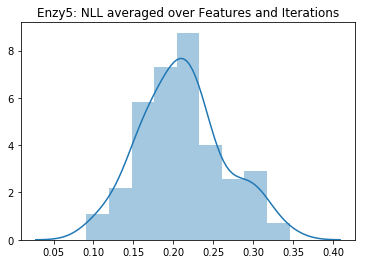

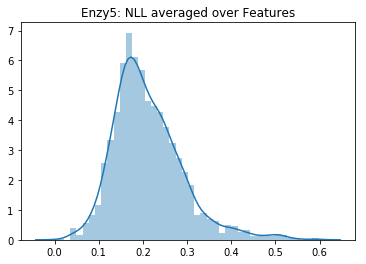

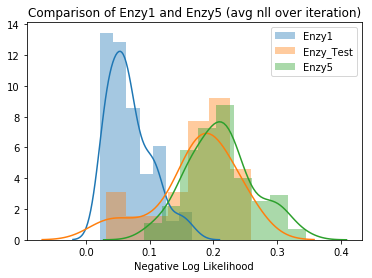

In [34]:
# Un-averaged nlls over the ladder normal distribution
plt.figure()
hist = sns.distplot(enzy5_nlls, kde=True)
plt.title("Enzy5: NLL summed over the features")

# Average the likelihoods across the iterations for each graph
plt.figure()
sns.distplot(enzy5_avg_nlls_iter,kde=True)
plt.title("Enzy5: NLL averaged over Features and Iterations")

# Average the likelihoods across the iterations for each graph
plt.figure()
sns.distplot(enzy5_avg_nlls,kde=True)
plt.title("Enzy5: NLL averaged over Features")

fig, ax = plt.subplots()
labels = ["Enzy1", "Enzy_Test", "Enzy5"]
likelihoods = [avg_nlls_iter, test_avg_nlls_iter, enzy5_avg_nlls_iter]
for i in range(len(labels)):
    sns.distplot(likelihoods[i], ax=ax, kde=True, label=labels[i])
ax.set_xlabel("Negative Log Likelihood")
ax.legend()
plt.title('Comparison of Enzy1 and Enzy5 (avg nll over iteration)')

## Enzyme 6

In [36]:
# Starting with enzyme with label 2
args_enzy6, graphs_enzy6 = get_graph_data("enzymes_6", isModelDataset=False)

# Create dataset and dataloader object for the out of distribution ladder dataset
# Note that instead of passing in args.max_prev_node, we pass in the saved max_prev_node
# saved specifically for the enzyme dataset - hack to allow for GraphRNN to work on any dataset
enzy6_dataset = Graph_sequence_sampler_pytorch_rand(graphs_enzy6,max_prev_node=max_prev_node,max_num_node=args_enzy6.max_num_node)
enzy6_loader = torch.utils.data.DataLoader(enzy6_dataset, batch_size=1, num_workers=args_enzy6.num_workers)

# Let's see how the nlls of the ladder graphs compare to 
# the trained on enzymes.
# Note we pass in the args_enzy because the model we are
# using are trained in the enzyme dataset
enzy6_nlls, enzy6_avg_nlls = calc_nll(args_enzy1, enzy6_loader, rnn, output, max_iter=25, train_dataset="enzymes_1", log=5)

enzy6_avg_nlls_iter = np.array(enzy6_avg_nlls)
enzy6_avg_nlls_iter = enzy6_avg_nlls_iter.reshape((25, len(enzy6_loader)))
enzy6_avg_nlls_iter = np.mean(enzy6_avg_nlls_iter, axis=0)

Loading graph dataset: ENZYMES
Loaded
Average num nodes 32.27956989247312
total graph num: 93
max number node: 88
max/min number edge: 133; 16
max previous node: 25
./model_save/GraphRNN_RNN_enzymes_1_4_128_lstm_3000.dat
model loaded!, epoch: 3000
Iteration: 5
Average Nll over train data: 153.478846334642
Iteration: 10
Average Nll over train data: 155.1376142809468
Iteration: 15
Average Nll over train data: 147.40716121017292
Iteration: 20
Average Nll over train data: 147.90302146378383
Iteration: 25
Average Nll over train data: 160.19015361416726


Text(0.5,1,'Comparison of Enzy1 and Enzy6 (avg nll over iteration)')

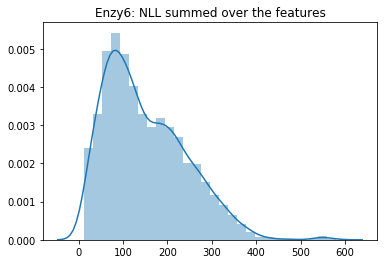

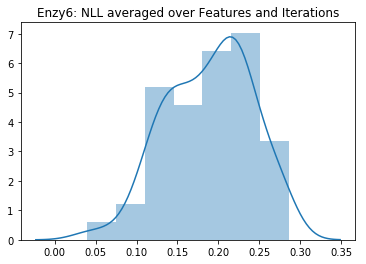

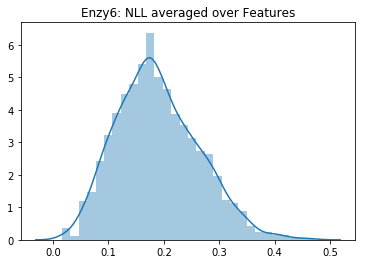

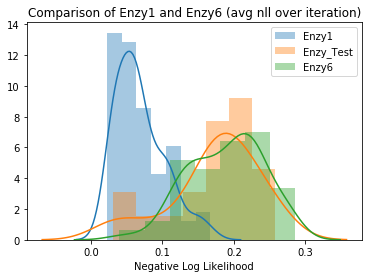

In [37]:
# Un-averaged nlls over the ladder normal distribution
plt.figure()
hist = sns.distplot(enzy6_nlls, kde=True)
plt.title("Enzy6: NLL summed over the features")

# Average the likelihoods across the iterations for each graph
plt.figure()
sns.distplot(enzy6_avg_nlls_iter,kde=True)
plt.title("Enzy6: NLL averaged over Features and Iterations")

# Average the likelihoods across the iterations for each graph
plt.figure()
sns.distplot(enzy6_avg_nlls,kde=True)
plt.title("Enzy6: NLL averaged over Features")

fig, ax = plt.subplots()
labels = ["Enzy1", "Enzy_Test", "Enzy6"]
likelihoods = [avg_nlls_iter, test_avg_nlls_iter, enzy6_avg_nlls_iter]
for i in range(len(labels)):
    sns.distplot(likelihoods[i], ax=ax, kde=True, label=labels[i])
ax.set_xlabel("Negative Log Likelihood")
ax.legend()
plt.title('Comparison of Enzy1 and Enzy6 (avg nll over iteration)')